In [12]:
import os
import fsps
import emcee
import numpy as np 
import scipy.optimize as op

In [70]:
# --- plotting --- 
import corner as DFM
from matplotlib import gridspec
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
tlb = np.load('/Users/chahah/data/provabgs/prior_correct/t.lookback.npy')
nlb = len(tlb)
tage = tlb[-1]

# delta t bin widths
dt = np.zeros(nlb)
dt[1:-1] = 0.5 * (np.diff(tlb)[1:] + np.diff(tlb)[:-1]) 
dt[0]   = 0.5 * (tlb[1] - tlb[0]) 
dt[-1]  = 0.5 * (tlb[-1] - tlb[-2]) 

In [4]:
lbls = ['constant', 'falling', 'rising', 'burst', 'quench']


wave = np.load('/Users/chahah/data/provabgs/prior_correct/wave.fsps.npy')

sfhs, seds = [], []
for lbl in lbls: 
    sfhs.append(np.load('/Users/chahah/data/provabgs/prior_correct/sfh.%s.npy' % lbl))
    seds.append(np.load('/Users/chahah/data/provabgs/prior_correct/sed.%s.npy' % lbl))

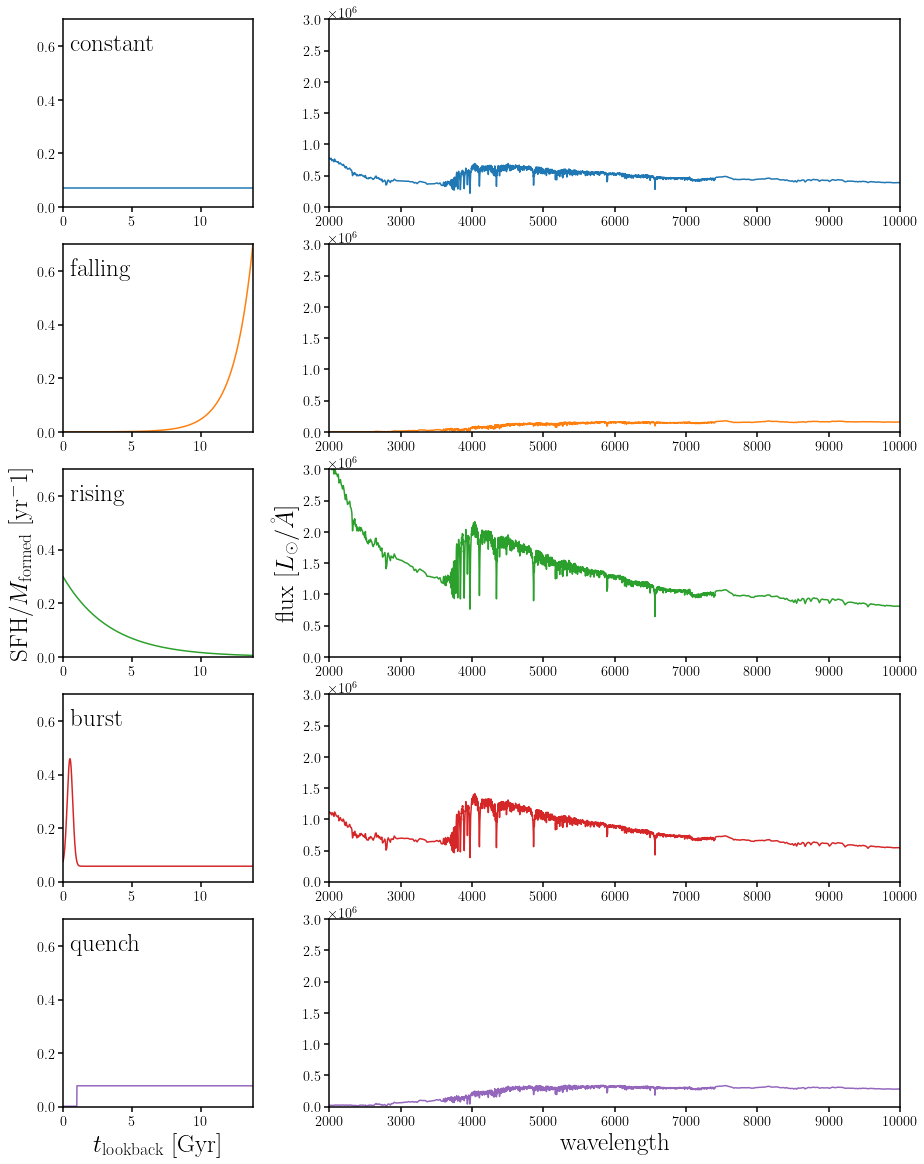

In [5]:
fig = plt.figure(figsize=(15,20))
gs = gridspec.GridSpec(5, 2, width_ratios=[1,3]) 
for i, sfh, sed, lbl in zip(range(5), sfhs, seds, lbls): 
    sub = plt.subplot(gs[i,0])
    sub.plot(tlb, sfh, c='C%i' % i, label=lbl)
    if i == 4: sub.set_xlabel(r'$t_{\rm lookback}$ [Gyr]', fontsize=25)
    sub.set_xlim(0, tage)
    if i == 2: sub.set_ylabel(r'SFH/$M_{\rm formed}$ [${\rm yr}^-1$]', fontsize=25)
    sub.set_ylim(0, 0.7)
    sub.text(0.5, 0.65, lbl, ha='left', va='top', fontsize=25)
    
    sub = plt.subplot(gs[i,1])
    sub.plot(wave, sed, c='C%i' % i, label=lbl)
    sub.set_xlim(2e3, 1e4)
    sub.set_ylim(0, 3e6)
    if i == 4: sub.set_xlabel('wavelength', fontsize=25)
    if i == 2: sub.set_ylabel(r'flux [$L_\odot/\AA$]', fontsize=25)

# run SED fitting on the mock data using a $\tau$-model SFH

In [6]:
tau_ssp = fsps.StellarPopulation(
    zcontinuous=1, # interpolate metallicities
    sfh=4,         # tau model
    dust_type=2,   # calzetti(2000)
    imf_type=1)    # chabrier IMF 

$\tau$ SED model

In [7]:
def sed_tau(theta): 
    ''' SED for a tau model with a burst
    '''
    tau_sfh, sf_start, fburst, tburst = theta
    # sfh parameters
    tau_ssp.params['tau']      = tau_sfh # e-folding time in Gyr 0.1 < tau < 10^2
    tau_ssp.params['sf_start'] = sf_start # start time of SFH in Gyr
    tau_ssp.params['fburst']   = fburst # fraction of mass formed in an instantaneous burst of star formation
    tau_ssp.params['tburst']   = tburst # age of the universe when burst occurs (tburst < tage) 
    tau_ssp.params['logzsol']  = 0 # log(z/zsun) 
    tau_ssp.params['dust2']    = 0.3  # dust2 parameter in fsps 

    w, l_ssp = tau_ssp.get_spectrum(tage=tage, peraa=True) 

    # mass normalization
    l_ssp *= (10**10)
    return w, l_ssp 

## define prior
Uniform priors on the 5 dimensions

In [8]:
def lnPrior(theta):
    ''' uniform priors on tau, sf start, fburst, tburst
    '''
    tau_sfh, sf_start, fburst, tburst = theta
    if ((0.1 < tau_sfh < 10) and 
        (0 < sf_start < tage) and 
        (0. < fburst < 1.) and 
        (0 < tburst < tage)): 
        return 0.
    return -np.inf 

## define likelihood and posterior
simple chi-squared likelihood

In [9]:
wlim = (wave > 2e3) & (wave < 1e4) # wavelength limit for convenience

def lnLike(theta, flux_obs, ivar_obs): 
    '''
    '''
    # get tau model SED
    w, flux_model = sed_tau(theta)
    
    # calculate chi2
    chi2 = np.sum((flux_obs - flux_model[wlim])**2 * ivar_obs)
    
    return -0.5 * chi2

def lnPost(theta, flux_obs, ivar_obs): 
    '''
    '''
    lp = lnPrior(theta)
    if not np.isfinite(lp): 
        return -np.inf
    
    lnlike = lnLike(theta, flux_obs, ivar_obs)
    
    return lp + lnlike

In [64]:
nwalkers, ndim = 20, 4
''' already run
samplers = []
for i, sed in enumerate(seds): 
    # initialize walkers
    _lnpost = lambda *args: -2. * lnPost(*args)
    min_result = op.minimize(
        _lnpost, 
        np.array([1., 0.9*tage, 0.1, 0.5*tage]), 
        args=(sed[wlim], np.ones(np.sum(wlim))))
    tt0 = min_result['x'] 
    logp0 = -0.5*min_result['fun']
    start = [tt0 + 1e-3 * np.random.randn(4) for i in range(nwalkers)]
    
    # run MCMC chain
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnPost, args=(sed[wlim], np.ones(np.sum(wlim))))
    sampler.run_mcmc(start, 10000)
    samplers.append(sampler)
'''

/opt/anaconda3/envs/gqp/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/opt/anaconda3/envs/gqp/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/opt/anaconda3/envs/gqp/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/opt/anaconda3/envs/gqp/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/opt/anaconda3/envs/gqp/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/opt/anaconda3/envs/gqp/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/opt/anaconda3/envs/gqp/lib/python3.7/site-packages/scipy/

In [81]:
# save the chains
for sampler, lbl in zip(samplers, lbls): 
    chain = sampler.get_chain()
    np.save('/Users/chahah/data/provabgs/prior_correct/mcmc.%s.nocorr.npy' % lbl, chain)

In [65]:
def SFH(theta): 
    ''' tau star formation history for given parameter values.
    '''
    from scipy.special import gammainc
    tau_sfh, sf_start, fburst, tburst = theta
    
    # tau or delayed-tau 
    power = 1 

    t = np.linspace(sf_start, tage, 1000)
    tlookback = t - sf_start
    dt = np.diff(t)[0]
    dts = np.repeat(dt, 1000)
    dts[0] *= 0.5
    dts[-1] *= 0.5

    tmax = (tage - sf_start) / tau_sfh
    normalized_t = (t - sf_start)/tau_sfh

    # constant contribution 
    sfh = np.zeros(1000)

    # burst contribution 
    tb = (tburst - sf_start) / tau_sfh
    if tb > 0 and fburst > 0: 
        iburst = np.floor(tb / dt * tau_sfh).astype(int)
        sfh[iburst] += fburst / dts[iburst]

    # tau contribution 
    ftau = (1.  - fburst) 
    sfh_tau = (normalized_t **(power - 1) * np.exp(-normalized_t))
    sfh += sfh_tau * (ftau / tau_sfh / np.trapz(sfh_tau, normalized_t))
    return tlookback, sfh 

[ 0.33688202 13.03410058  0.94384204  8.66792866]
[ 0.10000156 13.390106    0.99996324  1.64074456]
[ 0.39785331 13.08454094  0.82377903 11.14347971]
[ 0.14371631 13.095398    0.76957576  8.88209296]
[ 0.30412406 11.26501551  0.82850403  6.28196796]


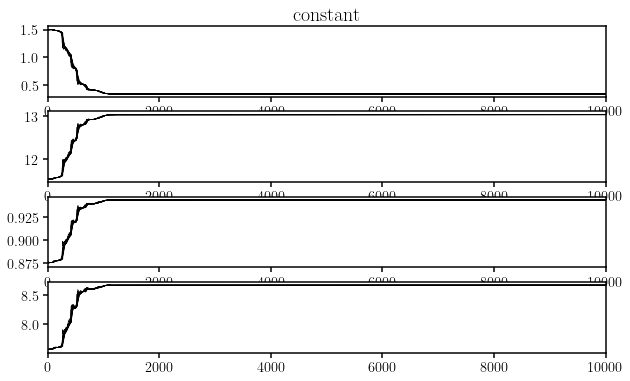

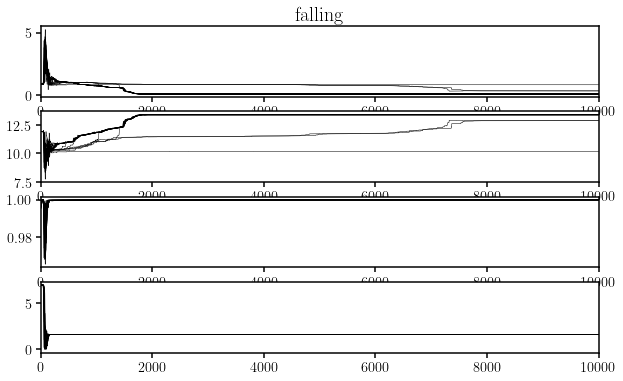

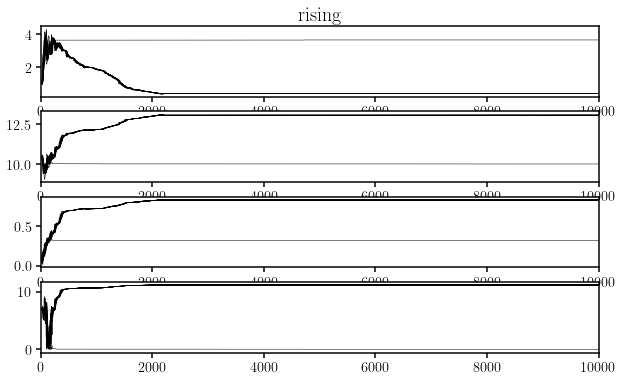

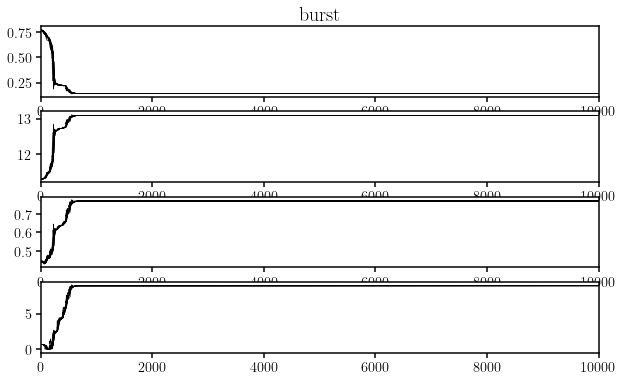

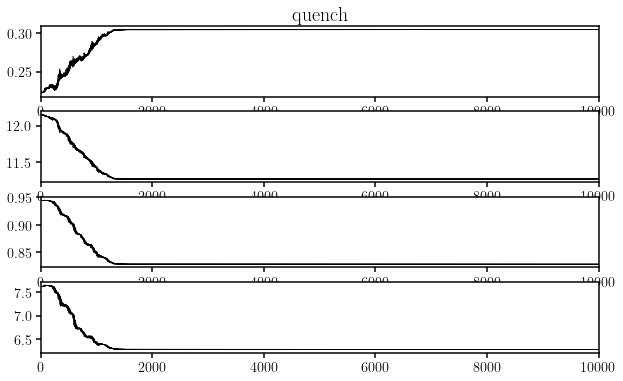

In [66]:
fluxes_bestfit, sfhs_bestfit = [], [] 
for sampler, lbl in zip(samplers, lbls): 
    chain = sampler.get_chain()
    
    fig = plt.figure(figsize=(10, 6))
    for ii in range(4): 
        sub = fig.add_subplot(4, 1, ii+1)
        for j in range(nwalkers): 
            sub.plot(chain[:,j,ii], c='k', lw=0.5)
        sub.set_xlim(0,10000)
        if ii == 0: sub.set_title(lbl, fontsize=20)
        
    flat_chain = sampler.get_chain(flat=True)
    theta_median = np.median(flat_chain[40000:,:], axis=0)
    # calculate bestfit SED
    _, flux_bestfit = sed_tau(theta_median)
    print(theta_median)
    # calculate bestfit SFH
    sfh_bestfit = SFH(theta_median)
    
    fluxes_bestfit.append(flux_bestfit)
    sfhs_bestfit.append(sfh_bestfit)

Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours


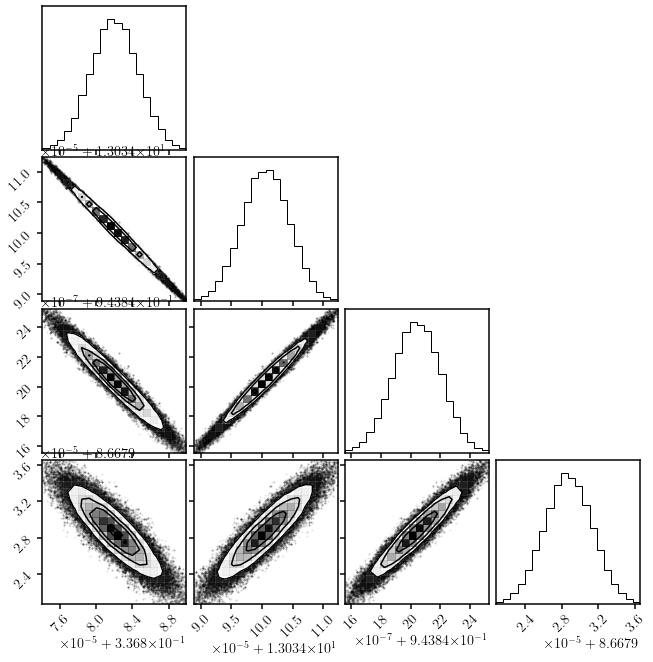

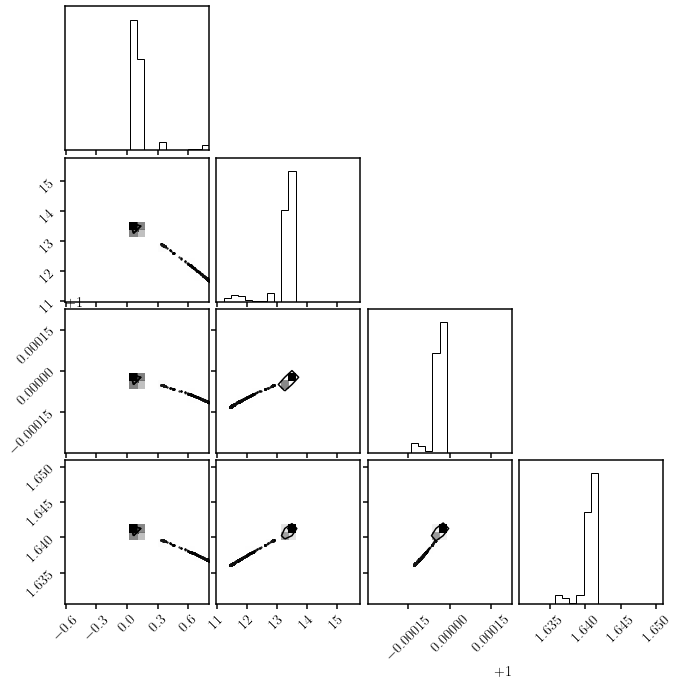

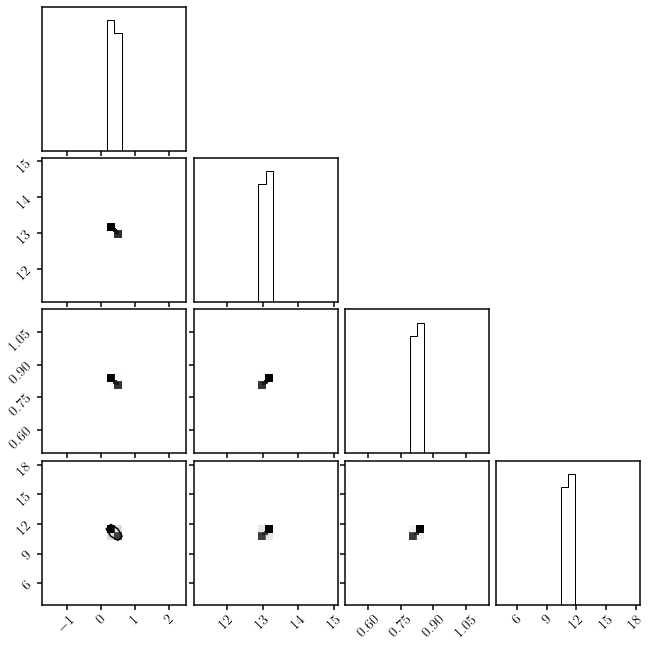

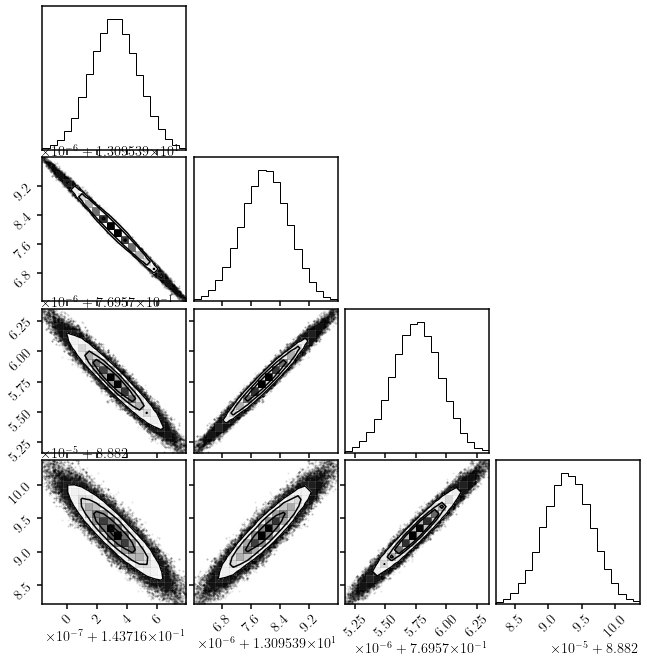

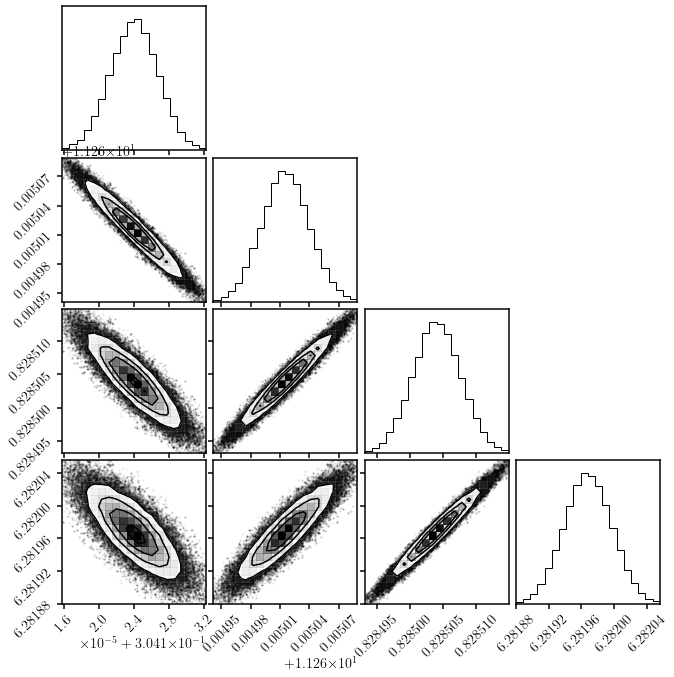

In [80]:
fluxes_bestfit, sfhs_bestfit = [], [] 
for sampler, lbl in zip(samplers, lbls): 
    flat_chain = sampler.get_chain(flat=True)
    theta_median = np.median(flat_chain[40000:,:], axis=0)
    std_median = np.std(flat_chain[40000:,:], axis=0)
    fig = DFM.corner(flat_chain[40000:,:], range=[(l, h) for l, h in zip(theta_median - 3*std_median, theta_median + 3*std_median)])

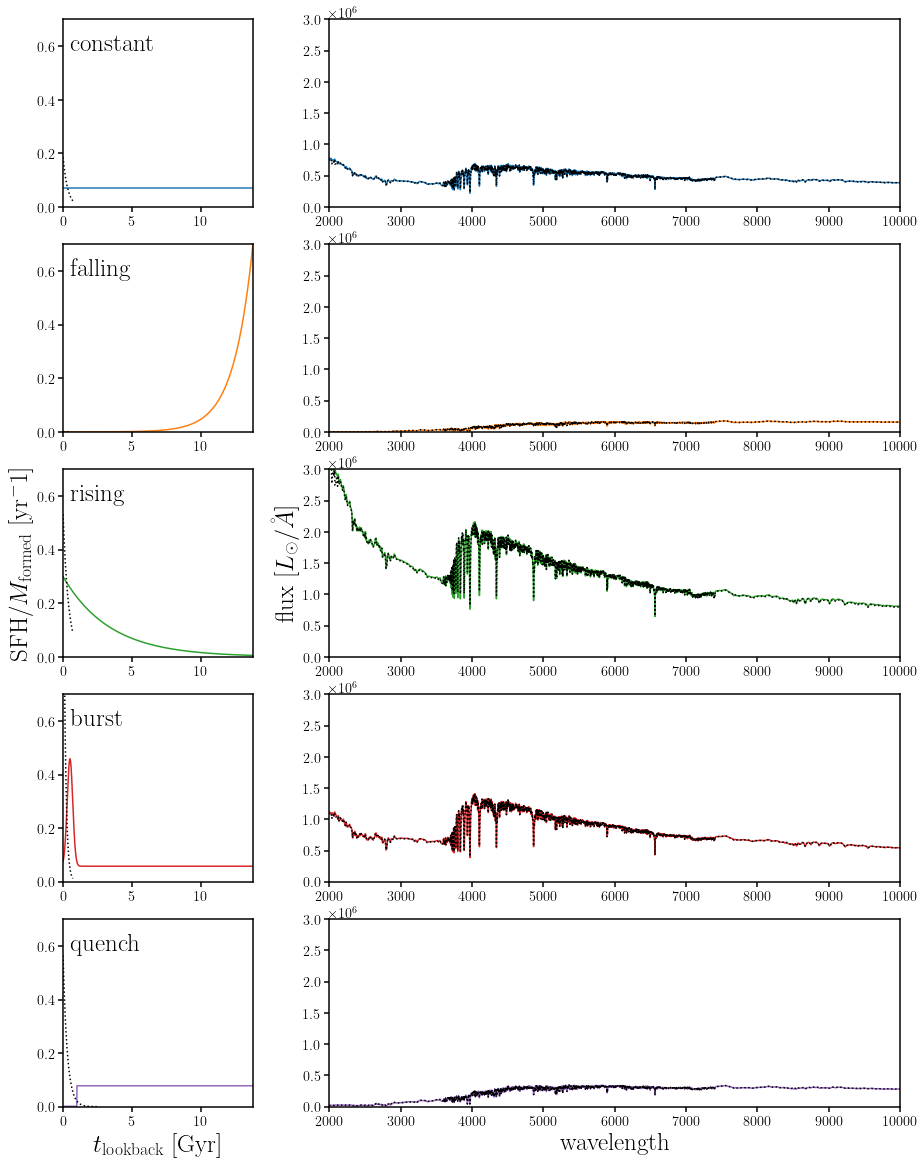

In [68]:
fig = plt.figure(figsize=(15,20))
gs = gridspec.GridSpec(5, 2, width_ratios=[1,3]) 
for i, sfh, sed, sfh_bf, flux_bf, lbl in zip(range(5), sfhs, seds, sfhs_bestfit, fluxes_bestfit, lbls): 
    sub = plt.subplot(gs[i,0])
    sub.plot(tlb, sfh, c='C%i' % i, label=lbl)
    sub.plot(sfh_bf[0], sfh_bf[1], c='k', ls=':')
    if i == 4: sub.set_xlabel(r'$t_{\rm lookback}$ [Gyr]', fontsize=25)
    sub.set_xlim(0, tage)
    if i == 2: sub.set_ylabel(r'SFH/$M_{\rm formed}$ [${\rm yr}^-1$]', fontsize=25)
    sub.set_ylim(0, 0.7)
    sub.text(0.5, 0.65, lbl, ha='left', va='top', fontsize=25)
    
    sub = plt.subplot(gs[i,1])
    sub.plot(wave, sed, c='C%i' % i, label=lbl)
    sub.plot(wave, flux_bf, c='k', ls=':')
    sub.set_xlim(2e3, 1e4)
    sub.set_ylim(0, 3e6)
    if i == 4: sub.set_xlabel('wavelength', fontsize=25)
    if i == 2: sub.set_ylabel(r'flux [$L_\odot/\AA$]', fontsize=25)